# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json


from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
import seaborn as sns #For Data visualization
import matplotlib.pyplot as plt #Data plotting and visualization
sns.set_palette(sns.color_palette('Set2'))

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

In [3]:
#Import functions
from clean_data import clean_portfolio, clean_profile, clean_transcript


portfolio_df = clean_portfolio(portfolio)
portfolio_df = portfolio_df[['offer_reward', 'channels', 'offer_difficulty', 
                             'offer_duration', 'offer_type', 'offer_id']]

profile_df = clean_profile(profile)
profile_df = profile_df[['gender','age', 'customer_id','became_member_on',
            'customer_income','membership_year','age_group']]

offers_df,transactions_df  = clean_transcript(transcript)


In [4]:
offers_df = offers_df[['customer_id', 'event', 'time_in_days', 'offer_id']]
offers_df

,customer_id,event,time_in_days,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0.00,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.00,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,29.75,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,29.75,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,29.75,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,29.75,fafdcd668e3743c1bb461111dcafc2a4


In [5]:
profile_df

,gender,age,customer_id,became_member_on,customer_income,membership_year,age_group
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,GenXers(44-56)
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,Boomers(57-75)
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,Boomers(57-75)
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,Boomers(57-75)
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,Boomers(57-75)
...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,GenXers(44-56)
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,Boomers(57-75)
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,GenXers(44-56)
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,Matures(76+)


## Portfolio: Data Exploration 

In [6]:
display(portfolio)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


## Profile: Data Exploration

In [8]:
profile_df

,gender,age,customer_id,became_member_on,customer_income,membership_year,age_group
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,GenXers(44-56)
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,Boomers(57-75)
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,Boomers(57-75)
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,Boomers(57-75)
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,Boomers(57-75)
...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,GenXers(44-56)
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,Boomers(57-75)
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,GenXers(44-56)
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,Matures(76+)


In [9]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


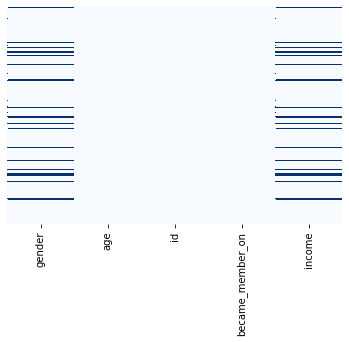

In [10]:
# Find and visualize Missing Data
sns.heatmap(profile.isnull(), yticklabels = False, cbar = False, cmap="Blues")

profile.info()

In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [12]:
print(pd.DataFrame(profile_df['age'].describe()))
print('')
print(pd.DataFrame(profile_df['customer_income'].describe()))

                age
count  14825.000000
mean      54.393524
std       17.383705
min       18.000000
25%       42.000000
50%       55.000000
75%       66.000000
max      101.000000

       customer_income
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000


<AxesSubplot:xlabel='age'>

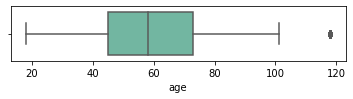

In [13]:
plt.figure(figsize=[6,1])
sns.boxplot(data=profile, x='age')

In [14]:
profile_df = profile_df[profile_df['customer_income'].notnull()]
print(profile_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   customer_id       14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   customer_income   14825 non-null  float64       
 5   membership_year   14825 non-null  int64         
 6   age_group         14825 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 825.4+ KB
None


Median Age  : $ 55.0


Text(0.5, 1.0, 'Age Distribution')

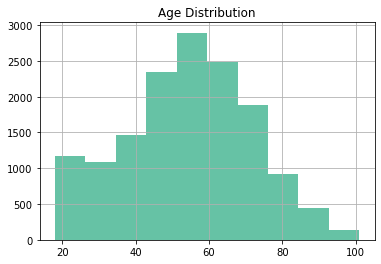

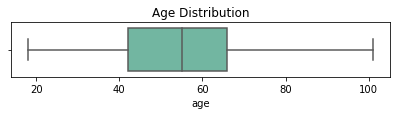

In [15]:
# Age Distributiobn:Histogram

profile_df['age'].hist(bins=10)

plt.title('Age Distribution')

#Age distribution: Box Plot

print("Median Age  : $",profile_df['age'].median())


plt.figure(figsize=[6.8,1])
sns.boxplot(data=profile_df, x='age')
plt.title('Age Distribution')

Code Age in terms of Generation criteria:
- Gen Z: 18 – 25
- Millennials: 26 – 43
- Gen Xers: 44 – 56
- Boomers: 57 – 75
- Matures: 76+ ]


Text(0.5, 1.0, 'Customer Age group')

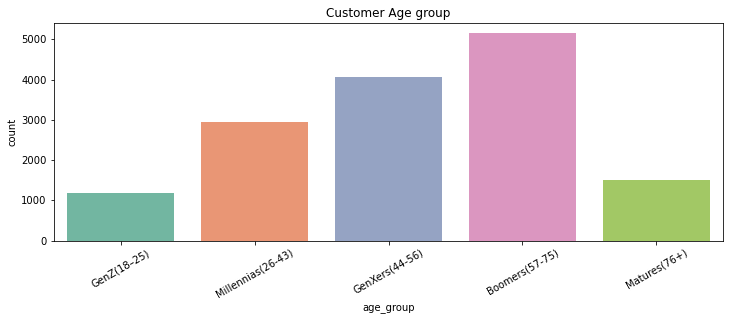

In [16]:
#Group the age ranges

fig = plt.figure(figsize = (12,4))
sns.countplot(x='age_group',data=profile_df)
plt.xticks(rotation=30)
plt.title('Customer Age group')

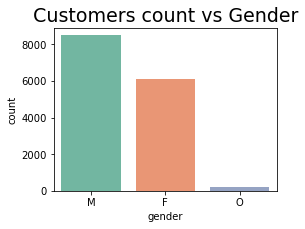

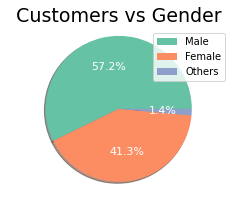

In [33]:
#Gender distribution

plt.figure(figsize=[4,3])
sns.countplot(x= profile_df['gender'], order = profile_df['gender'].value_counts().index)

plt.title('Customers count vs Gender', fontsize=19)

#Gender Distribution in Percentage

gender = profile_df['gender'].value_counts()

plt.figure(figsize=(4, 3))
plt.pie(gender, labels=['Male', 'Female' , 'Others'], shadow=True, autopct='%1.1f%%', 
            textprops={'color': "w", 'fontsize': 11})

plt.axis('equal')
plt.title('Customers vs Gender', fontsize=19)
plt.legend(loc='best')

In [34]:
gender

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [35]:
#Analyze income:

profile_df['customer_income'].describe()


count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: customer_income, dtype: float64

Text(0.5, 0, 'Salary(USD)')

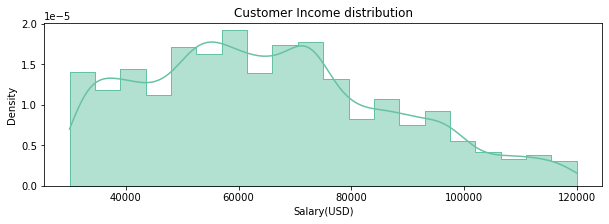

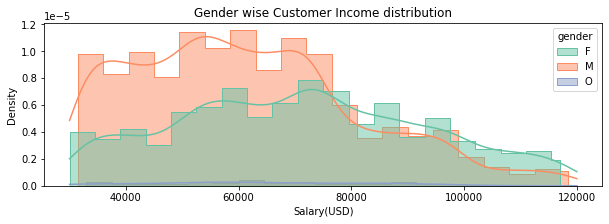

In [36]:
#Income distribution

plt.figure(figsize=[10,3])
sal_hist1 = sns.histplot(data = profile_df, x = 'customer_income',  multiple = "dodge",element = 'step', 
                        bins = 20, kde = True ,stat = 'density' ).set_title("Customer Income distribution")
plt.xlabel("Salary(USD)")

#Income distribution by gender

plt.figure(figsize=[10,3])
sal_hist = sns.histplot(data = profile_df, x = 'customer_income', hue = 'gender', 
                        multiple = "dodge",element = 'step', bins = 20, kde = True ,stat = 'density' ).set_title("Gender wise Customer Income distribution")
plt.xlabel("Salary(USD)")

In [37]:
#Median Income

print("Median Income  : $",profile_df['customer_income'].median())

print("Median Income for Males  : $",profile_df[profile_df['gender']=='M']['customer_income'].median())

print("Median Income Females : $",profile_df[profile_df['gender']=='F']['customer_income'].median())

Median Income  : $ 64000.0
Median Income for Males  : $ 59000.0
Median Income Females : $ 71000.0


In [41]:
#profile_df['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d') 

Text(0, 0.5, 'Number of Customers or Test Subjects')

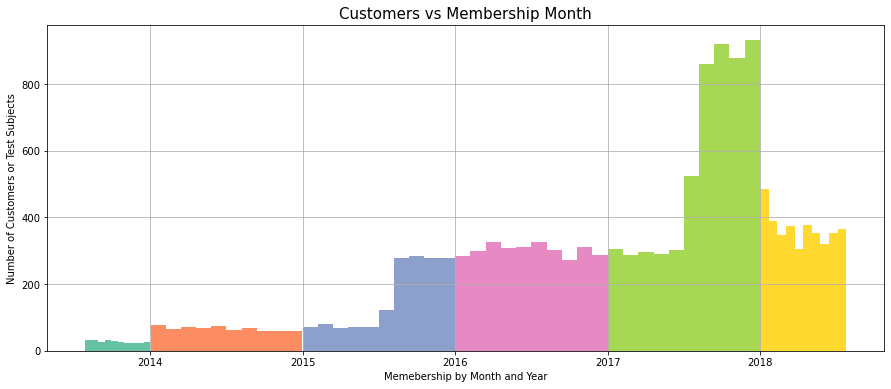

In [43]:
plt.figure(figsize=(15, 6))
profile_df['became_member_on'].groupby(profile_df['became_member_on'].dt.year) \
    .hist(bins=10)
plt.title('Customers vs Membership Month', fontsize=15)
plt.xlabel('Memebership by Month and Year')
plt.ylabel('Number of Customers or Test Subjects')

## Transcript: Data Exploration

In [44]:
#Transcript Data
transcript.head(4)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0


In [45]:
#Seperatng transaction and offer data from transcript dataframe
#offers, transactions = clean_transcript(transcript)

offers_df , transactions_df

(                             customer_id            event  time_in_days  \
 0       78afa995795e4d85b5d9ceeca43f5fef   offer received          0.00   
 1       a03223e636434f42ac4c3df47e8bac43   offer received          0.00   
 2       e2127556f4f64592b11af22de27a7932   offer received          0.00   
 3       8ec6ce2a7e7949b1bf142def7d0e0586   offer received          0.00   
 4       68617ca6246f4fbc85e91a2a49552598   offer received          0.00   
 ...                                  ...              ...           ...   
 306497  a6f84f4e976f44508c358cc9aba6d2b3  offer completed         29.75   
 306506  b895c57e8cd047a8872ce02aa54759d6  offer completed         29.75   
 306507  8dda575c2a1d44b9ac8e8b07b93d1f8e     offer viewed         29.75   
 306509  8431c16f8e1d440880db371a68f82dd0  offer completed         29.75   
 306527  24f56b5e1849462093931b164eb803b5  offer completed         29.75   
 
                                 offer_id  
 0       9b98b8c7a33c4b65b9aebfe6a799e6d9 

In [49]:

offers_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   customer_id   167581 non-null  object 
 1   event         167581 non-null  object 
 2   time_in_days  167581 non-null  float64
 3   offer_id      167581 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.4+ MB


In [50]:

transactions_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 12654 to 306533
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   customer_id   138953 non-null  object 
 1   event         138953 non-null  object 
 2   time_in_days  138953 non-null  float64
 3   amount        138953 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.3+ MB


In [51]:
offers_type = pd.merge(offers_df, portfolio_df, left_on='offer_id', right_on='offer_id', how='outer')
offers_type.head(2)

,customer_id,event,time_in_days,offer_id,offer_reward,channels,offer_difficulty,offer_duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo


In [52]:
data_all = pd.merge(offers_type, profile_df, left_on='customer_id', right_on='customer_id', how='outer')
data_all.head(2)

,customer_id,event,time_in_days,offer_id,offer_reward,channels,offer_difficulty,offer_duration,offer_type,gender,age,became_member_on,customer_income,membership_year,age_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75.0,2017-05-09,100000.0,2017.0,Boomers(57-75)
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75.0,2017-05-09,100000.0,2017.0,Boomers(57-75)


[Text(0.5, 0, ''), Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Informational')]

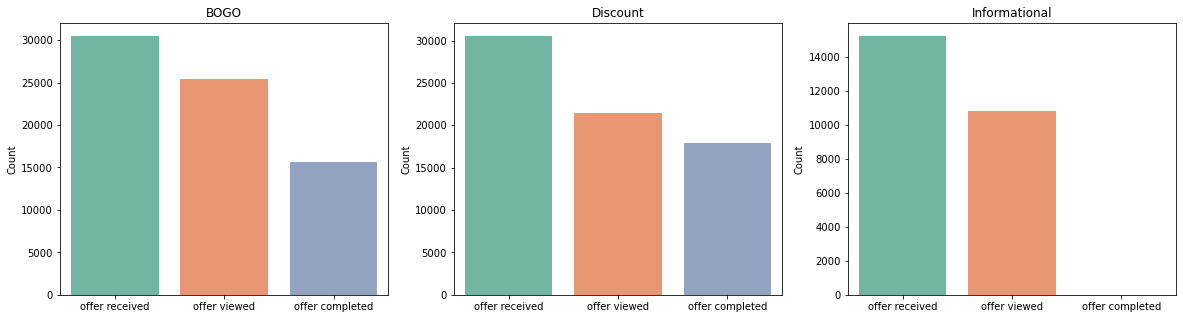

In [53]:
#Comparing offer recieved, viewed, completed by offer type

df_graph = offers_type.groupby(['event', 'offer_type'])['customer_id'].count().reset_index()
df_graph['event'] = pd.Categorical(df_graph['event'], ["offer received", "offer viewed", "offer completed"])

df_graph.sort_values('event', inplace = True)
df_graph = df_graph.rename(columns = {'customer_id':'customer_count'})

df_graph.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

sns.set_palette(sns.color_palette('Set2'))

ax = sns.barplot(x = 'event', y='customer_count', data=df_graph.query('offer_type == "bogo"'),ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot(x = 'event', y='customer_count', data=df_graph.query('offer_type == "discount"'),ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot(x = 'event', y='customer_count', data=df_graph.query('offer_type == "informational"'), ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

#### Explore Transactions

In [ ]:
transactions.head(5)

In [ ]:
pd.DataFrame(transactions['amount'].describe())

In [ ]:
transcript_by_person = transactions.groupby('customer_id')
pd.DataFrame(transcript_by_person['amount'].count().describe())

In [ ]:
transcript_by_person

In [ ]:
offers_type 